In [127]:
##          DATA SHAPE DEFINITION           ##

import numpy as np

# Define the parameters for the data shape
num_handsigns = 4
videos_per_handsign = 50
frames_per_video = 30
num_landmarks = 51
num_coordinates = 3

# Generate dummy data
data = [np.random.rand(videos_per_handsign, frames_per_video, num_landmarks, num_coordinates) for _ in range(num_handsigns)]

# Convert the list to a numpy array with shape (num_handsigns, videos_per_handsign, frames_per_video, num_landmarks, num_coordinates)
data_array = np.array(data)

# Save the data array to a .npy file
np.save('handsigns_data.npy', data_array)

In [128]:
##          PROCESS VIDEO DATASET FUNC DEFINITIONS         ##
import cv2
import mediapipe as mp
import numpy as np
import os
from tqdm import tqdm

def extract_landmarks(image, hands_results, pose_results):
    landmarks = []
    
    # Extract left hand landmarks (21 landmarks)
    if hands_results.multi_hand_landmarks and len(hands_results.multi_hand_landmarks) > 0:
        landmarks.extend([(lm.x, lm.y, lm.z) for lm in hands_results.multi_hand_landmarks[0].landmark])
    else:
        landmarks.extend([(0, 0, 0)] * 21)
    
    # Extract right hand landmarks (21 landmarks)
    if hands_results.multi_hand_landmarks and len(hands_results.multi_hand_landmarks) > 1:
        landmarks.extend([(lm.x, lm.y, lm.z) for lm in hands_results.multi_hand_landmarks[1].landmark])
    else:
        landmarks.extend([(0, 0, 0)] * 21)
    
    # Extract selected body landmarks (9 landmarks)
    selected_body_landmarks = [0, 11, 12, 13, 14, 15, 16, 23, 24]  # Landmarks for nose, arms, and shoulders
    if pose_results.pose_landmarks:
        for idx in selected_body_landmarks:
            lm = pose_results.pose_landmarks.landmark[idx]
            landmarks.append((lm.x, lm.y, lm.z))
    else:
        landmarks.extend([(0, 0, 0)] * 9)
    
    return np.array(landmarks)

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, frames_per_video, dtype=int)
    frame_set = set(indices)
    frame_count = 0
    
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands, \
         mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        
        while cap.isOpened() and len(frames) < frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count in frame_set:
                # Convert the BGR image to RGB
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Process the image and extract landmarks
                hands_results = hands.process(image)
                pose_results = pose.process(image)
                
                # Extract landmarks
                landmarks = extract_landmarks(image, hands_results, pose_results)
                
                frames.append(landmarks)
            
            frame_count += 1
    
    cap.release()
    
    # Pad if we don't have enough frames
    if len(frames) < frames_per_video:
        frames.extend([np.zeros((51, 3))] * (frames_per_video - len(frames)))
    
    return np.array(frames)

def process_dataset(root_path):
    data = []
    
    for handsign in tqdm(range(num_handsigns), desc="Processing handsigns"):
        handsign_path = os.path.join(root_path, f"handsign_{handsign+1}")  # Changed to match your folder naming
        if not os.path.exists(handsign_path):
            print(f"Warning: Directory {handsign_path} does not exist. Skipping.")
            data.append(np.zeros((videos_per_handsign, frames_per_video, 51, 3)))  # 51 landmarks total
            continue
        
        videos = [f for f in os.listdir(handsign_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        videos = videos[:videos_per_handsign]  # Limit to videos_per_handsign
        
        handsign_data = []
        for video in tqdm(videos, desc=f"Processing videos for handsign {handsign}", leave=False):
            video_path = os.path.join(handsign_path, video)
            video_data = process_video(video_path)
            handsign_data.append(video_data)
        
        # Pad if we don't have enough videos
        if len(handsign_data) < videos_per_handsign:
            handsign_data.extend([np.zeros((frames_per_video, 51, 3))] * (videos_per_handsign - len(handsign_data)))
        
        data.append(np.array(handsign_data))
    
    return np.array(data)


In [129]:
##          PROCESS VIDEOS DATASET FUNC CALLING         ##

if __name__ == "__main__":
    root_path = "TestDataset"  # Replace with your dataset root path
    
    data_array = process_dataset(root_path)
    
    # Save the data array to a .npy file
    np.save('handsigns_data.npy', data_array)
    print("Data saved to handsigns_data.npy")

Processing videos for handsign 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '

Processing handsigns: 100%|██████████| 4/4 [09:40<00:00, 145.10s/it]             

Data saved to handsigns_data.npy


In [150]:
##          MODEL DEFINITION            ##

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Input

# New input shape after reshaping
new_input_shape = (frames_per_video, num_landmarks * num_coordinates)

model = Sequential([
    # Input layer with the original shape
    Input(shape=(frames_per_video, num_landmarks, num_coordinates)),
    
    # Reshape layer to convert input shape from (30, 51, 3) to (30, 153)
    Reshape((frames_per_video, num_landmarks * num_coordinates)),
    
    # LSTM layers
    LSTM(64, return_sequences=True),
    LSTM(64),
    
    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(num_handsigns, activation='softmax')  # Assuming 60 handsigns
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.summary()


Epoch 1/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6463 - loss: 0.9580 - val_accuracy: 0.0000e+00 - val_loss: 6.2416
Epoch 2/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7445 - loss: 0.4205 - val_accuracy: 0.0000e+00 - val_loss: 6.2831
Epoch 3/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6618 - loss: 0.4851 - val_accuracy: 0.0000e+00 - val_loss: 6.8213
Epoch 4/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7305 - loss: 0.4422 - val_accuracy: 0.0000e+00 - val_loss: 6.4263
Epoch 5/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7177 - loss: 0.4060 - val_accuracy: 0.0000e+00 - val_loss: 7.1036
Epoch 6/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7991 - loss: 0.3895 - val_accuracy: 0.0000e+00 - val_loss: 6.1748
Epoch 7/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8837 - loss: 0.2780 - val_accuracy: 0.0000e+00 - val_loss: 6.8134
Epoch 8/250
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9684 - los

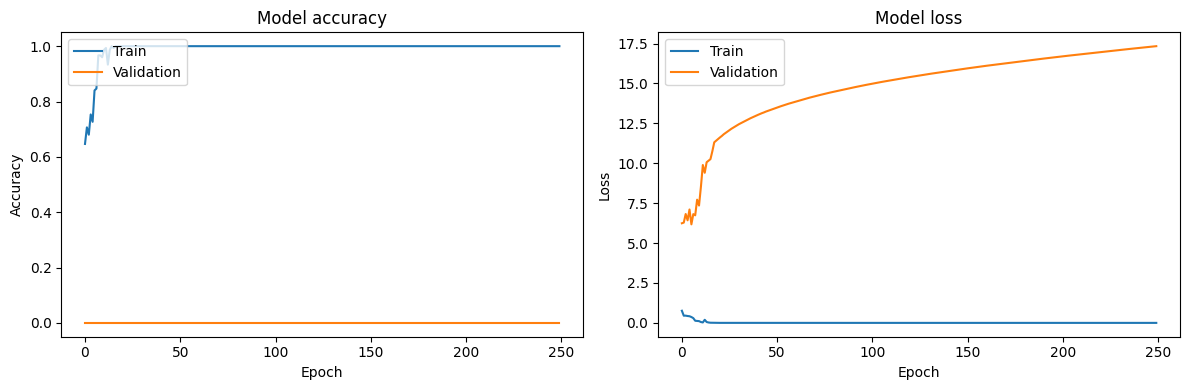

In [152]:
##          MODEL TRAINING          ##

# Load the data from the .npy file
data_array = np.load('handsigns_data.npy')

# X remains unchanged
X = data_array  # Shape: (60, 50, 30, 51, 3)

# Create labels for each handsign (0 to num_handsigns-1)
# This creates a label for each hand sign, repeated for each video
y = np.repeat(np.arange(num_handsigns), videos_per_handsign)
y = y.reshape(num_handsigns, videos_per_handsign)  # Shape: (60, 50)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

# We need to split along the first two axes (hand signs and videos)
train_indices, val_indices = train_test_split(
    np.arange(num_handsigns), 
    test_size=0.2, 
    random_state=42
)

X_train = X[train_indices]
X_val = X[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]

# Reshape X_train and X_val for the model
X_train = X_train.reshape(-1, frames_per_video, num_landmarks, num_coordinates)
X_val = X_val.reshape(-1, frames_per_video, num_landmarks, num_coordinates)

# Flatten y_train and y_val
y_train = y_train.flatten()
y_val = y_val.flatten()

# Train the model
history = model.fit(X_train, y_train, epochs=250, batch_size=10, validation_data=(X_val, y_val))

# Save the trained model
model.save('handsigns_model.h5')

# Optionally, save the training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    
    

##          TRAINING HISTORY ANALYSIS           ##
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# If you saved the history to a file, load it first:
# import pickle
# with open('training_history.pkl', 'rb') as f:
#     history = pickle.load(f)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# If you want to save the plot instead of displaying it:
# plt.savefig('training_history.png')

In [153]:
##          SINGLE VIDEO PREDICTION TEST         ##

def predict_handsign(video_path, model):
    # Process the video
    video_data = process_video(video_path)
    
    # Reshape the data to match the model input shape (Add batch dimension for single video prediction, this is necessary)
    video_data = video_data.reshape(1, frames_per_video, num_landmarks, num_coordinates)
    
    # Make prediction
    prediction = model.predict(video_data)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    return predicted_class, confidence

# Optional: Create a mapping of class indices to hand sign names
handsign_names = {
    0: "HandSign_1",
    1: "HandSign_2",
    2: "HandSign_3",
    3: "HandSign_4",
    # ... add more as needed
}

if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('handsigns_model.h5')
    
    # Specify the path to your video
    video_path = "../modelTestingAndExecution/testData/handsign_4/WIN_20240720_18_03_50_Pro.mp4"
    """
    # Predict the hand sign
    predicted_class, confidence = predict_handsign(video_path, model)
    """
    """
    # Get the name of the predicted hand sign (if mapping is provided)
    predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")
    
    # Print the result
    print(f"Predicted Hand Sign: {predicted_handsign}")
    print(f"Confidence: {confidence:.2f}")
    """
    
    # Optionally, you can add code here to process multiple videos in a directory
    # For example:
    
    test_directory = "../modelTestingAndExecution/testData/single videos"
    for video_file in os.listdir(test_directory):
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(test_directory, video_file)
            predicted_class, confidence = predict_handsign(video_path, model)
            predicted_handsign = handsign_names.get(predicted_class, f"HandSign_{predicted_class}")
            print(f"Video: {video_file}")
            print(f"Predicted Hand Sign: {predicted_handsign}")
            print(f"Confidence: {confidence:.2f}")
            print("--------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Video: #004WIN_20240720_18_03_50_Pro.mp4
Predicted Hand Sign: HandSign_1
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Video: #handsign_02_01.mp4
Predicted Hand Sign: HandSign_3
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Video: #handsign_02_02.mp4
Predicted Hand Sign: HandSign_1
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Video: 001_005_004.mp4
Predicted Hand Sign: HandSign_1
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Video: 001_008_003.mp4
Predicted Hand Sign: HandSign_1
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Video: 002_007_002.mp4
Predicted Hand Sign: HandSign_3
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Video: 002_009_003.mp4
Predicted Hand Sign: HandSign_3
Confidence: 1.00
--------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Video: 003_007_002

Processing handsigns: 100%|██████████| 4/4 [00:42<00:00, 10.68s/it]            


Test Loss: 1.5330
Test Accuracy: 0.2750
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.10      0.18        50
           1       0.00      0.00      0.00        50
           2       0.26      1.00      0.41        50
           3       0.00      0.00      0.00        50

    accuracy                           0.28       200
   macro avg       0.27      0.28      0.15       200
weighted avg       0.27      0.28      0.15       200



C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


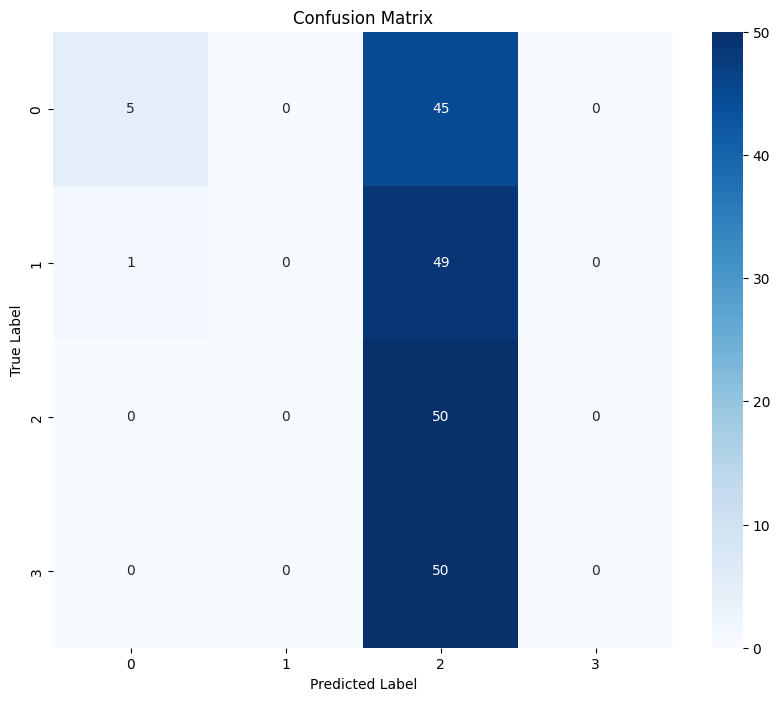

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


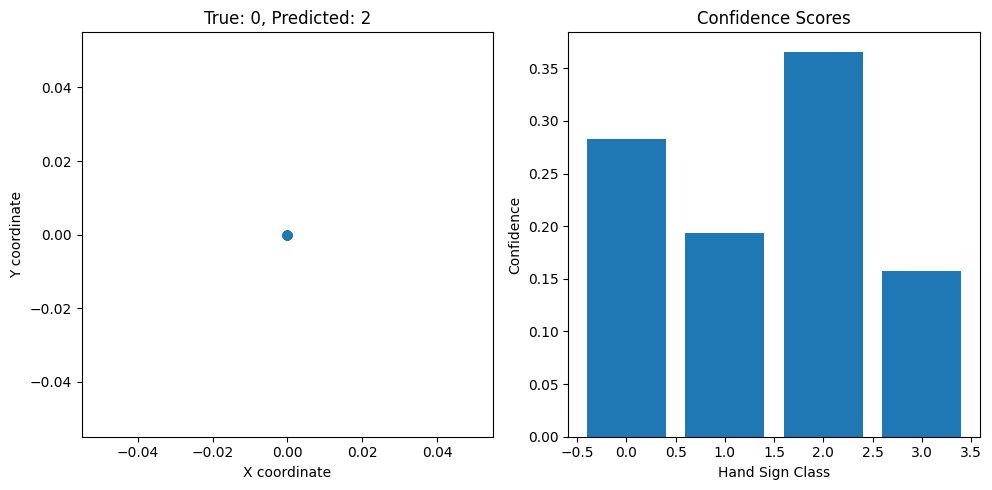

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


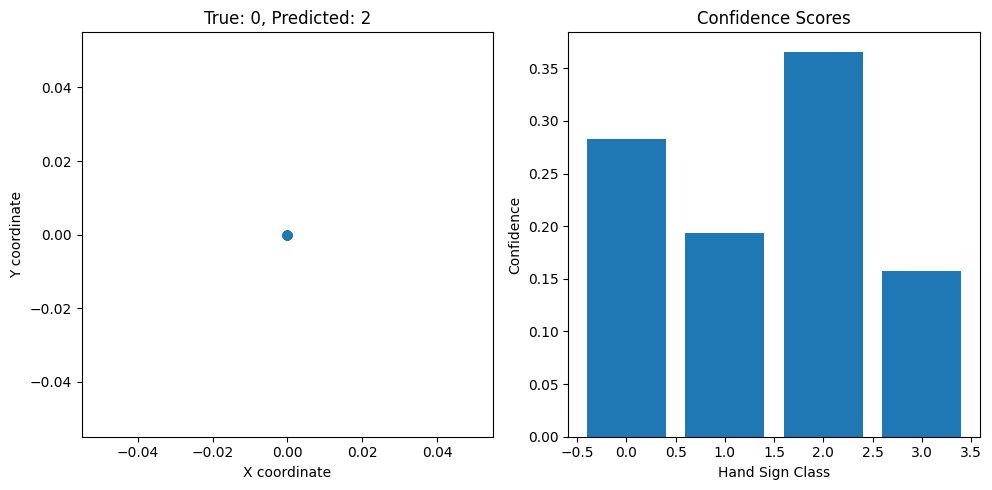

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


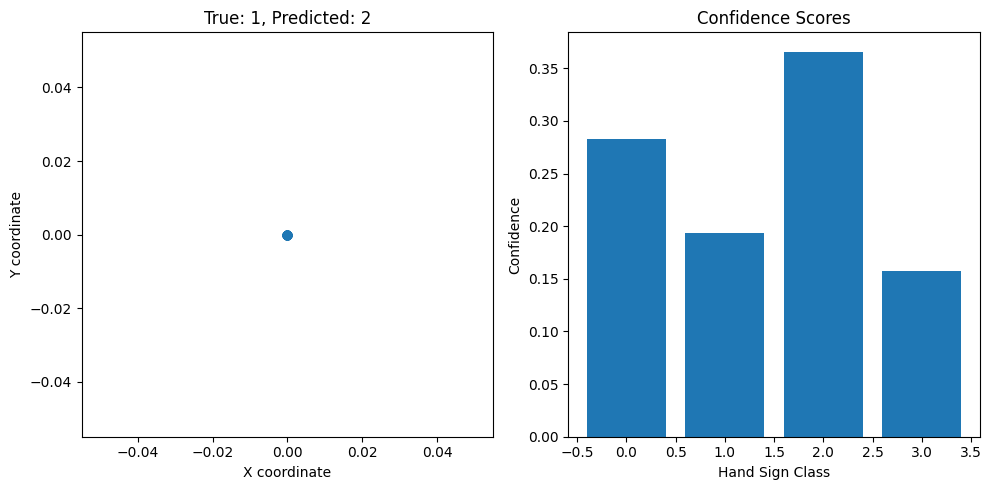

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


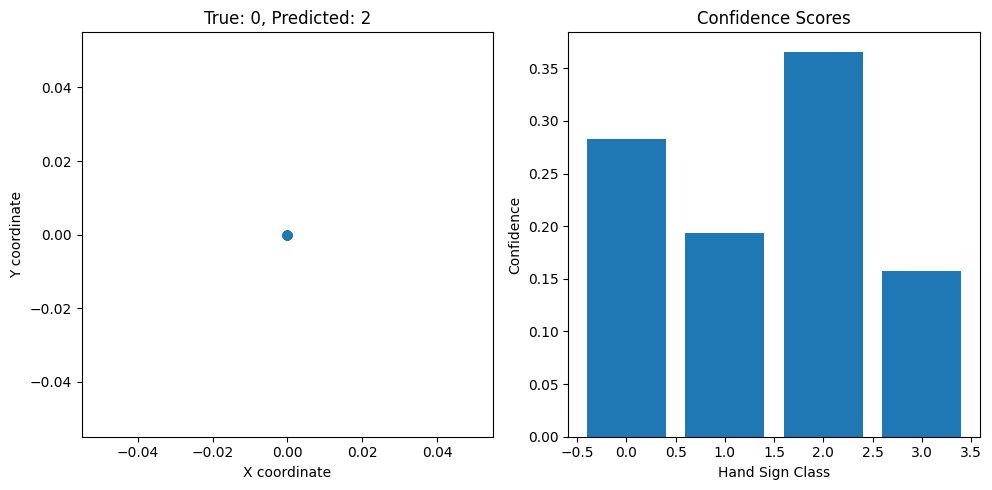

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


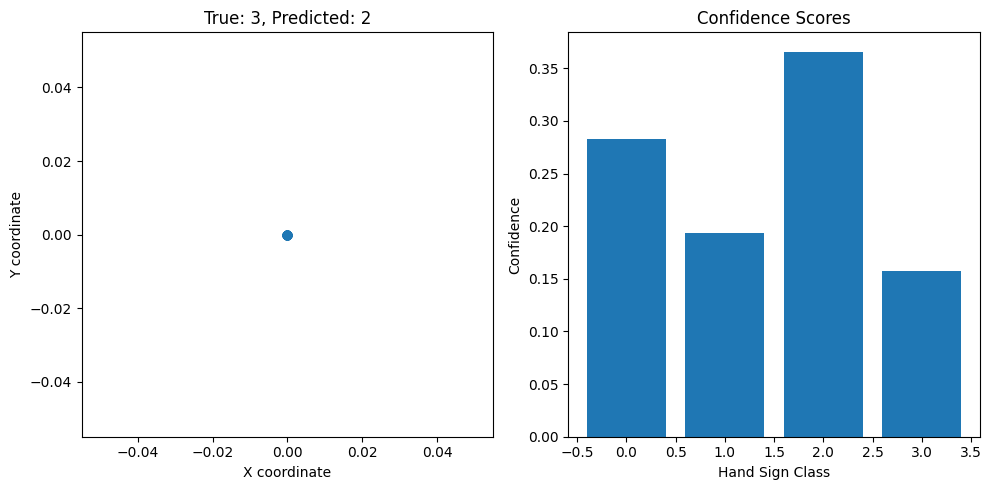

In [126]:
##          MODEL TESTING          ##

import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_test_data(test_data_path):
    # Reuse the process_dataset function
    test_data = process_dataset(test_data_path)
    
    # Reshape the data to match the model input shape
    X_test = test_data.reshape(-1, frames_per_video, num_landmarks, num_coordinates)
    y_test = np.repeat(np.arange(num_handsigns), videos_per_handsign)
    
    return X_test, y_test

def evaluate_model(model, X_test, y_test):
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    
    return y_pred_classes

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def visualize_misclassifications(X_test, y_test, y_pred, num_samples=5):
    misclassified = np.where(y_test != y_pred)[0]
    np.random.shuffle(misclassified)
    
    for i in range(min(num_samples, len(misclassified))):
        idx = misclassified[i]
        plt.figure(figsize=(10, 5))
        
        # Plot a representation of the hand sign (e.g., first frame landmarks)
        plt.subplot(1, 2, 1)
        plt.scatter(X_test[idx, 0, :, 0], X_test[idx, 0, :, 1])
        plt.title(f"True: {y_test[idx]}, Predicted: {y_pred[idx]}")
        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        
        # Plot the confidence scores for each class
        plt.subplot(1, 2, 2)
        confidence_scores = model.predict(X_test[idx:idx+1])[0]
        plt.bar(range(num_handsigns), confidence_scores)
        plt.title("Confidence Scores")
        plt.xlabel("Hand Sign Class")
        plt.ylabel("Confidence")
        
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Load the trained model
    model = tf.keras.models.load_model('handsigns_model.h5')
    
    # Load and preprocess test data
    test_data_path = "../modelTestingAndExecution/testData"  # Replace with your test dataset path
    X_test, y_test = load_and_preprocess_test_data(test_data_path)
    
    # Evaluate the model
    y_pred = evaluate_model(model, X_test, y_test)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    
    # Visualize some misclassifications
    visualize_misclassifications(X_test, y_test, y_pred)